**Поставленная задача**: 

В сфере открытых онлайн курсов существует проблема: средний процент людей, которые проходят курс до конца, меньше 5%. 

Нужно построить модель, которая будет предсказывать дропнется пользователь или нет, в первые несколько дней прохождения курса. Результаты такой модели можно использовать, чтобы предпринять некие меры для удержания пользователя и узнать переменные, которые определяют дропнувшегося пользователя. 

# Import libraries

In [ ]:
import numpy as np
import pandas as pd 

#visualization 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

#preprocessing 
import sklearn 
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve #
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve

#models
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Download datasets

In [ ]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

**Описание данных**:

***events_data*** - данные о действиях, которые совершают студенты на уроках (стэпах): 


*   *step_id* - id урока (стэпа);
*   *user_id* - анонимизированный id юзера;
*   *timestamp* - время наступления события в формате unix date;
*   *action* - события, возможные значения (discovered: переход на стэп; viewed: просмотр стэпа; started_attempt: начал решать; passed: сдал).

***submissions_data*** - данные о времени и статусах сабмитов к практическим заданиям:


*   *step_id* - id стэпа;
*   *timestamp* - время отправки решения в формате unix date;
*   *submission_status* - статус решения;
*   *user_id* - анонимизированный id юзера.


#Set the hyperparameters

In [ ]:
random_state = 0 

metrics_all = {1:'accurancy', 2:'precision', 3:'recall', 4:'f1', 5:'rocauc_score'}

latest_date_of_data = max(events_data.timestamp.max(), submissions_data.timestamp.max())
passed_course_score = int(76*0.9)
seconds_in_day = 24*60*60

In [ ]:
cv_n_split = 3
test_split_size = 0.15
metrics_now = [1, 2, 3, 4]

In [ ]:
drop_out_threshold = 20 * seconds_in_day
learning_time_threshold = 3 * seconds_in_day


#Feature engineering & Exploratory data analysis

In [ ]:
#разбираемся с датами
def add_date(df):
  '''
  переводит timestamp в формат datetime и перзаписывает в новую колонку, 
  добавляет колонку с датой
  '''
  df['date'] = pd.to_datetime(df.timestamp, unit='s')
  df['day'] = df.date.dt.date

add_date(events_data)
add_date(submissions_data)

In [ ]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
day                  object
dtype: object

95% of the data lower than 59.760440972222156
90% of the data lower than 18.325995370370403


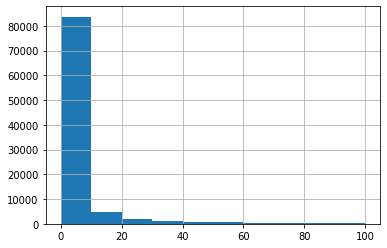

In [ ]:
#определяем количество дней после которого можно считать что пользователь дропнулся 
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id').timestamp.apply(np.array)\
    .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0) / (24*60*60))
gap_data[gap_data<100].hist()
print('95% of the data lower than', gap_data.quantile(0.95))
print('90% of the data lower than', gap_data.quantile(0.9))

In [ ]:
#создадим датафрейм с данными, необходимыми для определения целевой переменной и тренировочной выборки 
#человек прошел курс если правильно ответил на 90% степов с вопросами - 68 (76*0,9); дропнулся если после последнего посещения курса прошло более 20 дней.
#в остальных случаях человек считается проходящим курс без определенного статуса
#обучения проводим на пользователях, которые либо ушли, либо уже прошли курс

data_to_targetvariable = submissions_data.drop_duplicates(subset=['user_id', 'step_id', 'submission_status'])\
        .pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0)\
        .reset_index()[['user_id', 'correct']]

data_to_targetvariable = data_to_targetvariable.merge(
    events_data.groupby('user_id', as_index=False).timestamp.max(),
    on='user_id', how='right').fillna(0).rename({'timestamp':'last_timestamp'}, axis=1)

data_to_targetvariable['is_gone_user'] = (latest_date_of_data - data_to_targetvariable.last_timestamp) > drop_out_threshold
data_to_targetvariable['passed_course'] = data_to_targetvariable.correct >= passed_course_score

data_to_targetvariable.shape

(19234, 5)

In [ ]:
data_to_targetvariable.head()

,user_id,correct,last_timestamp,is_gone_user,passed_course
0,1,0.0,1472827464,True,False
1,2,2.0,1519226966,True,False
2,3,29.0,1444581588,True,False
3,5,2.0,1499859939,True,False
4,7,0.0,1521634660,True,False


In [ ]:
#чтобы делать выводы на основе первых трех дней, который юзер проводит на платформе, нужно отобрать только те действия, 
#которые юзер совершил в первые три дня
#сначала создаем табличку где собираем данные о дате первой сессии и считаем три дня от нее

user_min_time = events_data.groupby('user_id', as_index=False).agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'}, axis=1)
user_min_time['user_learning_time_threshold'] = user_min_time.user_id.map(str) + '_' + \
                                                (user_min_time.min_timestamp + learning_time_threshold).map(str)

user_min_time.nunique()

user_id                         19234
min_timestamp                   19223
user_learning_time_threshold    19234
dtype: int64

In [ ]:
def select_kdays_data(df):
  '''
  отбирает данные первых k дней для каждого юзера
  '''
  df['user_time'] = df.user_id.map(str) + '_' + df.timestamp.map(str)
  df = df.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')
  data_train = df[df.user_time <= df.user_learning_time_threshold]
  if data_train.groupby('user_id').day.nunique().max() != (learning_time_threshold / seconds_in_day + 1):
    print('Something went wrong')
  return df, data_train 

events_data, events_data_train = select_kdays_data(events_data)
submissions_data, submissions_data_train = select_kdays_data(submissions_data)

In [ ]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_threshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434605177


In [ ]:
  #собираем данные, необходимые для обучения модели: количество активных дней из трех доступных, количество пройденых степов
  #количество правильных и неправильных ответов, их соотношение и количество просмотренных степов
  
  X = submissions_data_train.groupby('user_id', as_index=False).day.nunique().rename({'day':'days'}, axis=1)
  steps_tried = submissions_data_train.groupby('user_id', as_index=False).step_id.nunique().rename({'step_id':'steps_tried'})
  X = X.merge(steps_tried, on='user_id', how='outer')
  X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                     columns='submission_status', 
                                     values='step_id',
                                     aggfunc='count',
                                     fill_value=0).reset_index())
  X['correct_ratio'] = X.correct / (X.correct + X.wrong)
  X = X.merge(events_data_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0)\
                              .reset_index()[['user_id', 'viewed']])
  X = X.merge(data_to_targetvariable[['user_id', 'passed_course', 'is_gone_user']], how='outer').fillna(0)

In [ ]:
X.head()

,user_id,days,step_id,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9.0,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20.0,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154.0,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9.0,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132.0,True,True


In [ ]:
#из всех данных нам нужно выбрать пользователей, которые уже либо сдали, либо ушли, остальных откидываем, 
#так как, на данный момент, мы не можем их точно никак класифицировать 

X = X[-((X.passed_course==False)&(X.is_gone_user==False))]
y = X.passed_course
y = pd.Series(np.where(np.array(y)==True, 1, 0))
X = X.drop(['passed_course', 'is_gone_user'], axis=1)
X.head()

,user_id,days,step_id,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9.0
1,3,1.0,4.0,4.0,4.0,0.50,20.0
2,8,1.0,11.0,9.0,21.0,0.30,154.0
3,14,1.0,1.0,0.0,1.0,0.00,9.0
4,16,3.0,23.0,23.0,27.0,0.46,132.0


In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    1
dtype: int64

# Preparing to modeling

In [ ]:
#Standartization
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [ ]:
# For boosting model
Xb = X.copy()
# Synthesis valid as test for selection models
X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb, y, test_size=test_split_size, random_state=random_state)

In [ ]:
# For models from Sklearn
# Normalization
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [ ]:
# Synthesis valid as test for selection models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split_size, random_state=random_state)

In [ ]:
# Splitting train data for model tuning with cross-validation
cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_split_size, random_state=random_state)

In [ ]:
acc_all = np.empty((10, len(metrics_now)*2)).tolist()


def acc_metrics_calc(num, model, X_train, X_test, y_train, y_test):
  '''
  Calculation of accuracy of model by different metrics
  '''
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  global acc_all
  
  num_acc = 0 
  for metric in metrics_now:
    if metric == 1:
      #accuracy_score
      acc_train = round(accuracy_score(y_train, train_predict) * 100, 2)
      acc_test = round(accuracy_score(y_test, test_predict) * 100, 2)
    elif metric == 2:
      #precision_score
      acc_train = round(precision_score(y_train, train_predict) * 100, 2)
      acc_test = round(precision_score(y_test, test_predict) * 100, 2)
    elif metric == 3:
      #recall_score 
      acc_train = round(recall_score(y_train, train_predict) * 100, 2)
      acc_test = round(recall_score(y_test, test_predict) * 100, 2)
    elif metric == 4:
      #f1_score
      acc_train = round(f1_score(y_train, train_predict) * 100, 2)
      acc_test = round(f1_score(y_test, test_predict) * 100, 2)
    print(metrics_all[metric], 'for train =', acc_train)
    print(metrics_all[metric], 'for test =', acc_test)
    acc_all[num][num_acc] = acc_train #train
    acc_all[num][num_acc+1] = acc_test #test
    num_acc += 2


In [ ]:
acc_all[0]

[4.4365257e-317,
 1.63736e-318,
 3.71453e-319,
 4.5252e-319,
 4.83937e-319,
 1.049005e-318,
 5.94633e-319,
 4.24936e-319]

In [ ]:
def plot_learning_curve(estimator, title, X, y, cv=cv_train, train_sizes=np.linspace(.1, 1.0, 5), 
                        random_state=random_state):
    """
    Generate the test and training learning curve.
    
    """
    plt.figure(figsize=(20, 5))

    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    cv_train = ShuffleSplit(n_splits=cv_n_split, test_size=test_split_size, random_state=random_state)
    
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator=estimator, X=X, y=y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    plt.legend(loc="best")

    plt.show()
    return



#Tuning models and test

In [ ]:
%%time
# Support Vector Machines

svr = SVC()
svr_CV = GridSearchCV(svr, param_grid={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                                       'tol': [1e-4]}, 
                      cv=cv_train, verbose=False)
svr_CV.fit(X_train, y_train)
print('Best parameters for SVM:', svr_CV.best_params_, '\n')
acc_metrics_calc(0, svr_CV, X_train, X_test, y_train, y_test)

Best parameters for SVM: {'kernel': 'rbf', 'tol': 0.0001} 

accurancy for train = 92.68
accurancy for test = 93.07
precision for train = 72.45
precision for test = 88.89
recall for train = 6.01
recall for test = 7.84
f1 for train = 11.09
f1 for test = 14.41
CPU times: user 2min 42s, sys: 283 ms, total: 2min 43s
Wall time: 2min 42s


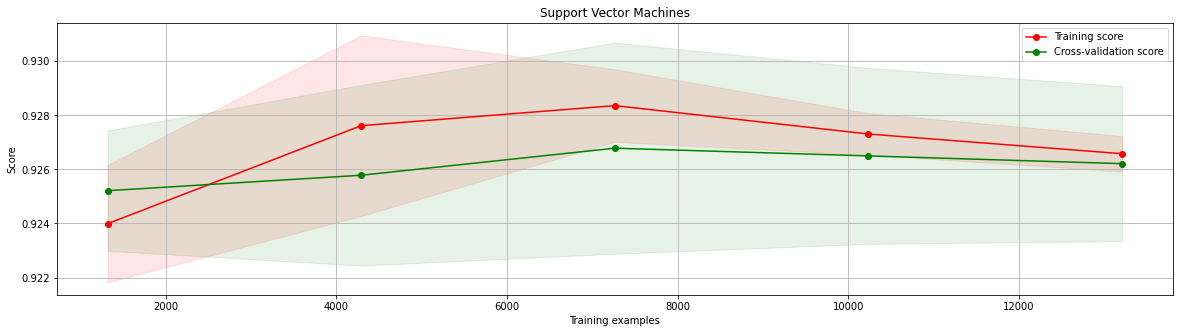

In [ ]:
# Building learning curve of model
plot_learning_curve(svr, "Support Vector Machines", X_train, y_train)

In [ ]:
%%time
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
param_grid = {'min_samples_leaf': [i for i in range(2,10)]}
decision_tree_CV = GridSearchCV(decision_tree, param_grid=param_grid, cv=cv_train, verbose=False)
decision_tree_CV.fit(X_train, y_train)
print('Best parameters for Decision Tree:', decision_tree_CV.best_params_, '\n')
acc_metrics_calc(1, decision_tree_CV, X_train, X_test, y_train, y_test)

Best parameters for Decision Tree: {'min_samples_leaf': 9} 

accurancy for train = 93.97
accurancy for test = 91.83
precision for train = 70.87
precision for test = 38.64
recall for train = 35.19
recall for test = 16.67
f1 for train = 47.03
f1 for test = 23.29
CPU times: user 1.18 s, sys: 1.03 ms, total: 1.18 s
Wall time: 1.18 s


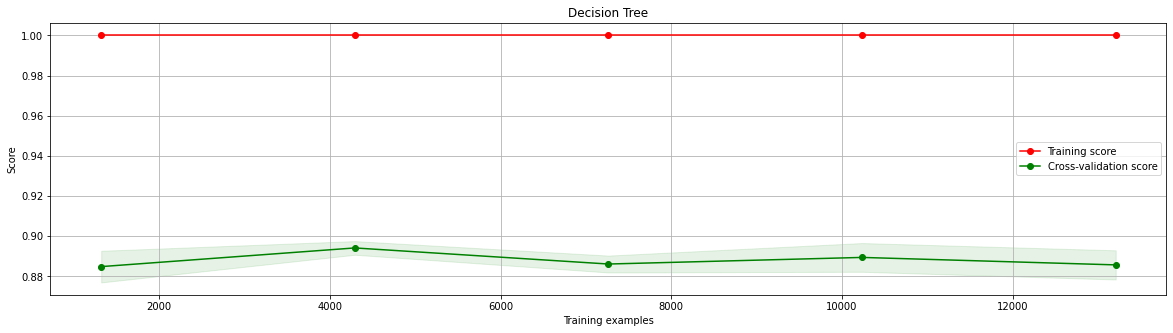

In [ ]:
# Building learning curve of model
plot_learning_curve(decision_tree, "Decision Tree", X_train, y_train)

In [ ]:
%%time
# Random Forest

random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [300, 400, 500, 600], 'min_samples_split': [60], 'min_samples_leaf': [20, 25, 30, 35, 40], 
              'max_features': ['auto'], 'max_depth': [5, 6, 7, 8, 9, 10], 'criterion': ['gini'], 'bootstrap': [False]}
random_forest_CV = GridSearchCV(estimator=random_forest, param_grid=param_grid, 
                             cv=cv_train, verbose=False)
random_forest_CV.fit(X_train, y_train)
print('Best parameters for Random Forest:', random_forest_CV.best_params_, '\n')
acc_metrics_calc(2, random_forest_CV, X_train, X_test, y_train, y_test)

Best parameters for Random Forest: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 20, 'min_samples_split': 60, 'n_estimators': 500} 

accurancy for train = 92.79
accurancy for test = 93.07
precision for train = 72.59
precision for test = 73.33
recall for train = 8.29
recall for test = 10.78
f1 for train = 14.88
f1 for test = 18.8
CPU times: user 27min 30s, sys: 2.96 s, total: 27min 33s
Wall time: 27min 29s


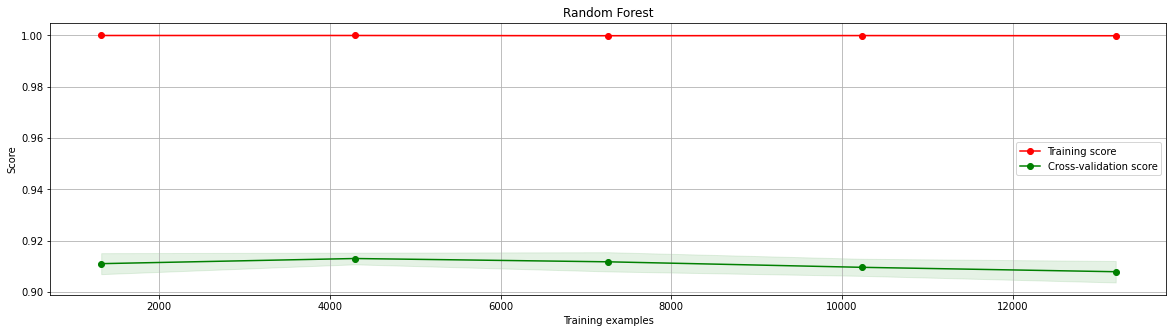

In [ ]:
# Building learning curve of model
plot_learning_curve(random_forest, "Random Forest", X_train, y_train)

In [ ]:
%%time
# XGBoost Classifier

xgb_clf = xgb.XGBClassifier(objective='reg:squarederror') 
parameters = {'n_estimators': [200, 300, 400], 
              'learning_rate': [0.001, 0.003, 0.005, 0.006, 0.01],
              'max_depth': [4, 5, 6]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=cv_train).fit(X_train, y_train)
print("Best parameters for XGBoost Classifier:", xgb_reg.best_params_, '\n')
acc_metrics_calc(3, xgb_reg, X_trainb, X_testb, y_trainb, y_testb)

Best parameters for XGBoost Classifier: {'learning_rate': 0.001, 'max_depth': 5, 'n_estimators': 400} 

accurancy for train = 87.04
accurancy for test = 87.39
precision for train = 29.66
precision for test = 28.99
recall for train = 51.27
recall for test = 48.04
f1 for train = 37.58
f1 for test = 36.16
CPU times: user 5min 30s, sys: 985 ms, total: 5min 31s
Wall time: 5min 29s


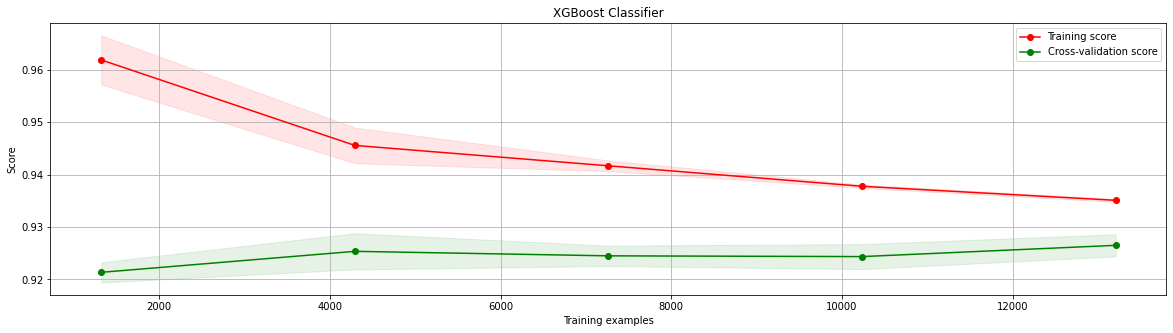

In [ ]:
# Building learning curve of model
plot_learning_curve(xgb_clf, "XGBoost Classifier", X_trainb, y_trainb)

In [ ]:
%%time
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier()
param_grid = {'learning_rate' : [0.001, 0.01, 0.1],
              'max_depth': [i for i in range(2,5)],
              'min_samples_leaf': [i for i in range(2,5)]}
gradient_boosting_CV = GridSearchCV(estimator=gradient_boosting, param_grid=param_grid, 
                                    cv=cv_train, verbose=False)
gradient_boosting_CV.fit(X_train, y_train)
print("Best parameters for Gradient Boosting Classifier:", gradient_boosting_CV.best_params_, '\n')
acc_metrics_calc(4, gradient_boosting_CV, X_train, X_test, y_train, y_test)

Best parameters for Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 2} 

accurancy for train = 93.06
accurancy for test = 93.11
precision for train = 73.73
precision for test = 68.29
recall for train = 13.54
recall for test = 13.73
f1 for train = 22.87
f1 for test = 22.86
CPU times: user 1min 33s, sys: 106 ms, total: 1min 33s
Wall time: 1min 33s


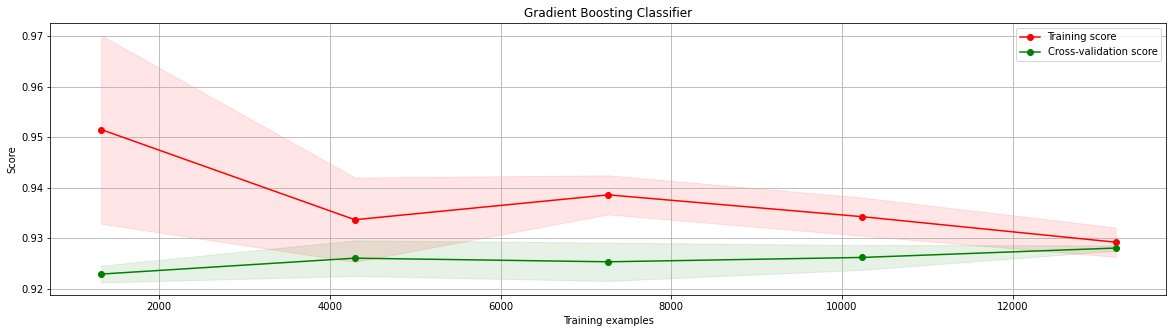

In [ ]:
# Building learning curve of model
plot_learning_curve(gradient_boosting_CV, "Gradient Boosting Classifier", X_train, y_train)

In [ ]:
%%time
# Bagging Classifier

bagging = BaggingClassifier()
param_grid={'max_features': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'n_estimators': [3, 5, 10],
            'warm_start' : [True],
            'random_state': [random_state]}
bagging_CV = GridSearchCV(estimator=bagging, param_grid=param_grid, cv=cv_train, verbose=False)
bagging_CV.fit(X_train, y_train)
print("Best parameters for Bagging Classifier:", bagging_CV.best_params_, '/n')
acc_metrics_calc(5, bagging_CV, X_train, X_test, y_train, y_test)

Best parameters for Bagging Classifier: {'max_features': 0.5, 'n_estimators': 10, 'random_state': 0, 'warm_start': True} /n
accurancy for train = 97.15
accurancy for test = 91.83
precision for train = 99.46
precision for test = 35.71
recall for train = 62.86
recall for test = 12.25
f1 for train = 77.03
f1 for test = 18.25
CPU times: user 7.11 s, sys: 28 ms, total: 7.14 s
Wall time: 7.13 s


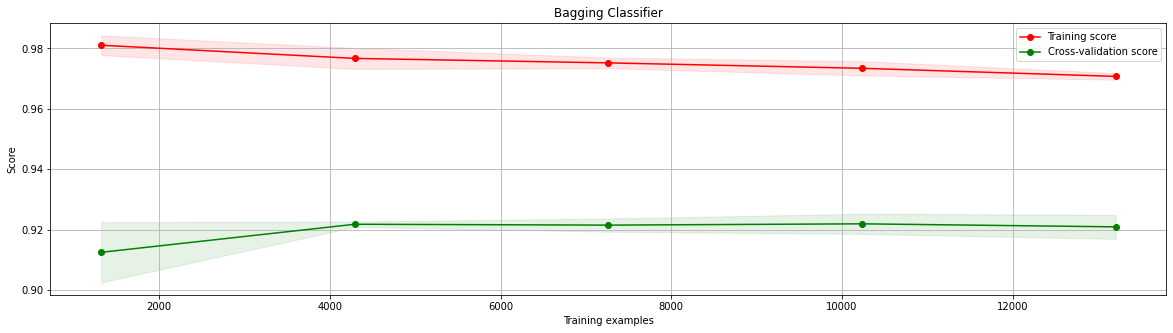

In [ ]:
# Building learning curve of model
plot_learning_curve(bagging_CV, "Bagging Classifier", X_train, y_train)

In [ ]:
%%time
# Logistic Regression

logreg = LogisticRegression()
logreg_CV = GridSearchCV(estimator=logreg, param_grid={'C' : [.1, .3, .5, .7, 1]}, cv=cv_train, verbose=False)
logreg_CV.fit(X_train, y_train)
acc_metrics_calc(6, logreg_CV, X_train, X_test, y_train, y_test)

accurancy for train = 92.66
accurancy for test = 93.22
precision for train = 59.13
precision for test = 70.45
recall for train = 11.51
recall for test = 15.2
f1 for train = 19.26
f1 for test = 25.0
CPU times: user 1.34 s, sys: 1.01 s, total: 2.35 s
Wall time: 1.21 s


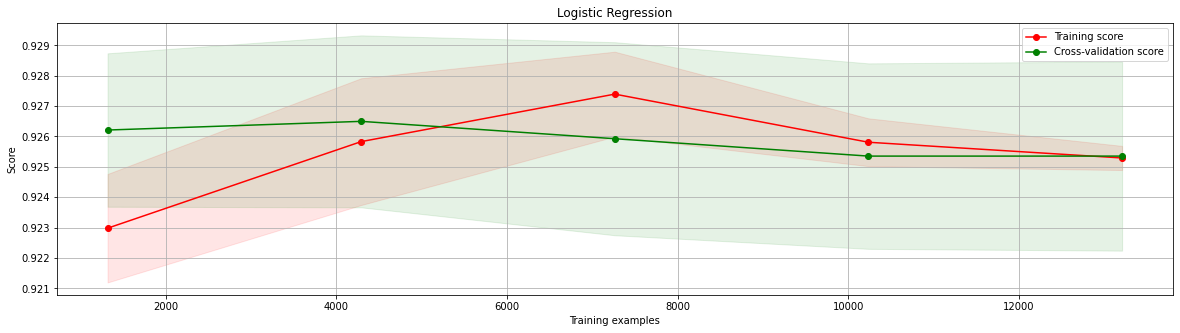

In [ ]:
# Building learning curve of model
plot_learning_curve(logreg, "Logistic Regression", X_train, y_train)

In [ ]:
%%time
# KNN - k-Nearest Neighbors algorithm

knn = KNeighborsClassifier()
param_grid={'n_neighbors': range(2, 7)}
knn_CV = GridSearchCV(estimator=knn, param_grid=param_grid, 
                      cv=cv_train, verbose=False).fit(X_train, y_train)
print("Best parameters for KNN:", knn_CV.best_params_, '\n')
acc_metrics_calc(7, knn_CV, X_train, X_test, y_train, y_test)

Best parameters for KNN: {'n_neighbors': 6} 

accurancy for train = 93.22
accurancy for test = 92.67
precision for train = 71.77
precision for test = 53.19
recall for train = 17.85
recall for test = 12.25
f1 for train = 28.59
f1 for test = 19.92
CPU times: user 2.65 s, sys: 15 ms, total: 2.67 s
Wall time: 2.66 s


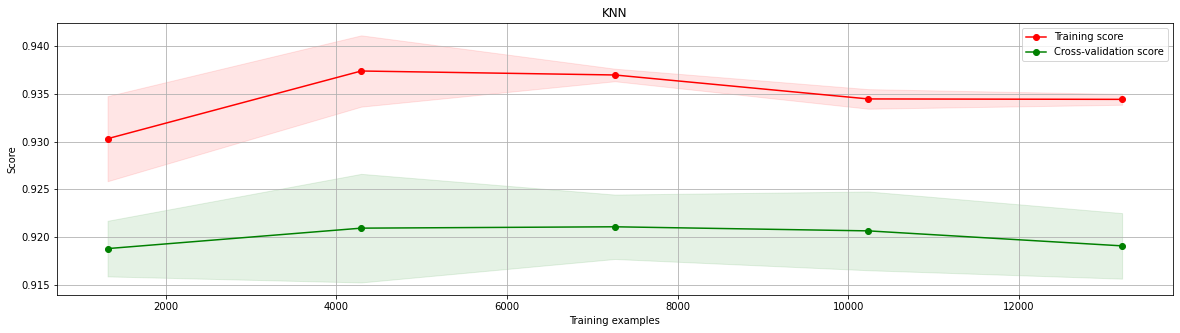

In [ ]:
# Building learning curve of model
plot_learning_curve(knn, "KNN", X_train, y_train)

In [ ]:
%%time
# Gaussian Naive Bayes

gaussian = GaussianNB()
param_grid={'var_smoothing': [1e-8, 1e-9, 1e-10]}
gaussian_CV = GridSearchCV(estimator=gaussian, param_grid=param_grid, cv=cv_train, verbose=False)
gaussian_CV.fit(X_train, y_train)
print("Best parameters for Gaussian Naive Bayes:", gaussian_CV.best_params_, '\n')
acc_metrics_calc(8, gaussian_CV, X_train, X_test, y_train, y_test)

Best parameters for Gaussian Naive Bayes: {'var_smoothing': 1e-08} 

accurancy for train = 89.17
accurancy for test = 89.32
precision for train = 35.35
precision for test = 33.82
recall for train = 51.02
recall for test = 45.59
f1 for train = 41.76
f1 for test = 38.83
CPU times: user 104 ms, sys: 2.01 ms, total: 106 ms
Wall time: 102 ms


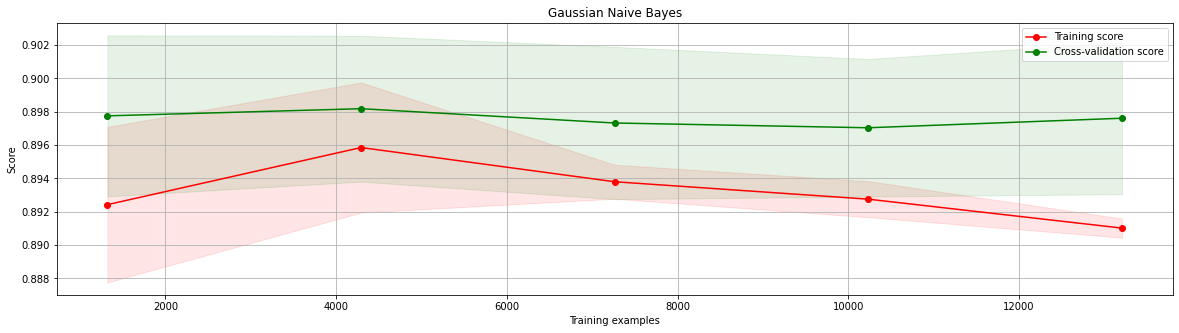

In [ ]:
# Building learning curve of model
plot_learning_curve(gaussian, "Gaussian Naive Bayes", X_train, y_train)

In [ ]:
%%time
# Perceptron

perceptron = Perceptron()
param_grid = {'penalty': [None, 'l2', 'l1', 'elasticnet']}
perceptron_CV = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=cv_train, verbose=False)
perceptron_CV.fit(X_train, y_train)
print("Best parameters for Perceptron:", perceptron_CV.best_params_, '\n')
acc_metrics_calc(9, perceptron_CV, X_train, X_test, y_train, y_test)

Best parameters for Perceptron: {'penalty': None} 

accurancy for train = 92.71
accurancy for test = 93.04
precision for train = 57.49
precision for test = 61.4
recall for train = 16.24
recall for test = 17.16
f1 for train = 25.33
f1 for test = 26.82
CPU times: user 377 ms, sys: 280 ms, total: 657 ms
Wall time: 354 ms


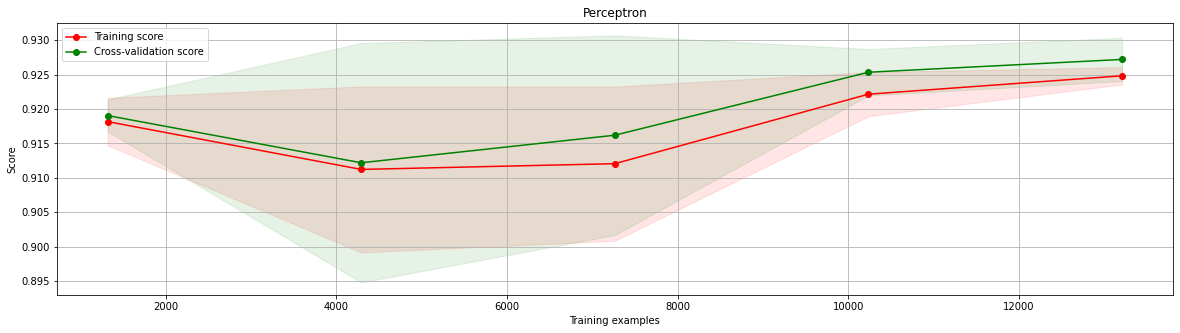

In [ ]:
# Building learning curve of model
plot_learning_curve(perceptron, "Perceptron", X_train, y_train)

# Models comparison

In [ ]:
model_data = pd.DataFrame(acc_all, index=['SVM', 'Decision_Tree', 'Random_Forest', 'XGBoost_Classifier', 'Gradient_Boosting_Classifier', 
                             'Bagging_Classifier', 'Logistic_Regression', 'KNN', 'Gaussian_Naive_Bayes', 'Perceptron'], 
             columns=['acc_tran', 'acc_test', 'pre_train', 'pre_train', 
                      'rec_train', 'rec_test', 'f1_train', 'f1_test'])

Выборка не сбалансированная, поэтому использовать accurancy не совсем корректно. Так как у нас нет четкого указания, что для нас важнее не пропустить пользователя или минимизировать ложные срабатывание, как ключевую метрику будем использовать f-меру. 

In [ ]:
model_data.sort_values(ascending=False, by='f1_test')

,acc_tran,acc_test,pre_train,pre_train,rec_train,rec_test,f1_train,f1_test
Gaussian_Naive_Bayes,89.17,89.32,35.35,33.82,51.02,45.59,41.76,38.83
XGBoost_Classifier,87.04,87.39,29.66,28.99,51.27,48.04,37.58,36.16
Perceptron,92.71,93.04,57.49,61.40,16.24,17.16,25.33,26.82
Logistic_Regression,92.66,93.22,59.13,70.45,11.51,15.20,19.26,25.00
Decision_Tree,93.97,91.83,70.87,38.64,35.19,16.67,47.03,23.29
Gradient_Boosting_Classifier,93.06,93.11,73.73,68.29,13.54,13.73,22.87,22.86
KNN,93.22,92.67,71.77,53.19,17.85,12.25,28.59,19.92
Random_Forest,92.79,93.07,72.59,73.33,8.29,10.78,14.88,18.80
Bagging_Classifier,97.15,91.83,99.46,35.71,62.86,12.25,77.03,18.25
SVM,92.68,93.07,72.45,88.89,6.01,7.84,11.09,14.41
